# Introduction

[Dataset in Kaggle](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data)

[Paper](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5): Davide Chicco, Giuseppe Jurman: Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Medical Informatics and Decision Making 20, 16 (2020). 




# Data Cleaning and Exploration

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Set up figure directory; prepare for a Flask web app
FIG_DIR = "../flask/static"

In [2]:
df = pd.read_csv('../data/heart_failure_clinical_records_dataset.csv')

In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In the original dataset there is a typo with a superflous *ni* in `creati(ni)ne_phosphokinase` (`serum_creatinine` is correct).

In [4]:
df.columns = ' '.join(df.columns).replace('creatinine_ph',
                                          'creatine_ph').split()
df.columns

Index(['age', 'anaemia', 'creatine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

The column `sex` should be interpreted (as mentioned in the paper) as `Male` for value 1 and `Female` for value 0. Let's rename it to `Male` for clarity.

In [5]:
df.columns = ' '.join(df.columns).replace('sex', 'Male').split()
df.columns

Index(['age', 'anaemia', 'creatine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'Male', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

Below we assign label categories to variables and then inspect the shape and descriptive statistics of the dataset.

In [6]:
LABEL = "DEATH_EVENT"  # store target label
POS_LABEL, NEG_LABEL = "Deceased", "Survived"

In [7]:
df.shape

(299, 13)

In [8]:
df.describe()

,age,anaemia,creatine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,Male,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


For convenience, let's rescale platelets by dividing by 1000.

In [9]:
df['platelets'] /= 1000

In [10]:
df[LABEL].sum() / df.shape[0]

0.3210702341137124

32% of patients passed away. The dataset is imbalanced and requires a stratified split into train and test sets, later on.

The column names should have units and improved formatting. We take the former from the paper.
Then, we split into binary and non_binary features and store this information in a "metadata" dictionary.
This way, it will be easier to, for example, create a web input form where a user would, accordingly, type in or select the binary value. If we had categorical features, we could provide also "choice" information (e.g. patient's nationality) such that the form "knows" about the possible options.

Moreover, we shall make different plots for binary and non-binary variables.

In [11]:
from pprint import PrettyPrinter as PP
units = {
    'age': 'years',
    'creatine_phosphokinase': 'mcg/L',
    'ejection_fraction': '%',
    'platelets': '1000 platelets/mL',  # multipled by 1000 wrt paper
    'serum_creatinine': 'mg/dL',
    'serum_sodium': 'mEq/L',
    'time': 'days'
}


def improve_col_name(name):
    title = name.replace('_', ' ').title()  # Title-like text
    unit = units.get(name, None)  # unit or empty string
    if unit:
        return title + f' [{unit}]'  # eg 'mass [kg]'
    return title


# Improve column names
df.columns = [improve_col_name(c) for c in df.columns if c != LABEL] + [LABEL]
print("New columns:", df.columns)


def is_binary(key):
    return df[key].unique().size == 2


# Store feature metadata (useful for web forms).
# One might add more properties if needed.
feature_metadata = {c: {'is_binary': is_binary(c)} for c in df.columns}

# Print feature metadata
pp = PP(indent=4)
print("\nFeature metadata:")
pp.pprint(feature_metadata)

New columns: Index(['Age [years]', 'Anaemia', 'Creatine Phosphokinase [mcg/L]', 'Diabetes',
       'Ejection Fraction [%]', 'High Blood Pressure',
       'Platelets [1000 platelets/mL]', 'Serum Creatinine [mg/dL]',
       'Serum Sodium [mEq/L]', 'Male', 'Smoking', 'Time [days]',
       'DEATH_EVENT'],
      dtype='object')

Feature metadata:
{   'Age [years]': {'is_binary': False},
    'Anaemia': {'is_binary': True},
    'Creatine Phosphokinase [mcg/L]': {'is_binary': False},
    'DEATH_EVENT': {'is_binary': True},
    'Diabetes': {'is_binary': True},
    'Ejection Fraction [%]': {'is_binary': False},
    'High Blood Pressure': {'is_binary': True},
    'Male': {'is_binary': True},
    'Platelets [1000 platelets/mL]': {'is_binary': False},
    'Serum Creatinine [mg/dL]': {'is_binary': False},
    'Serum Sodium [mEq/L]': {'is_binary': False},
    'Smoking': {'is_binary': True},
    'Time [days]': {'is_binary': False}}


Let us plot the binary features.

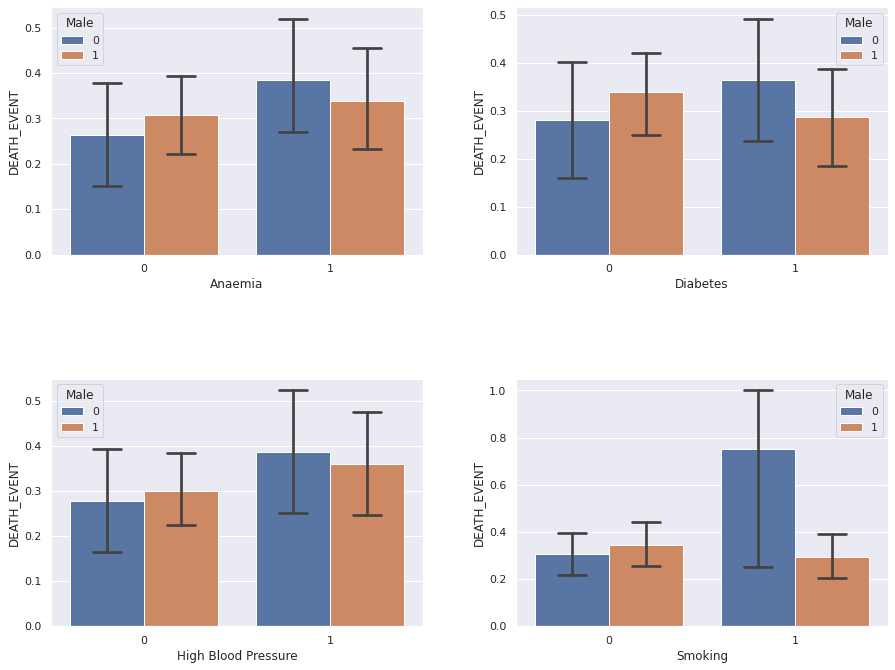

In [12]:
def plot_features(binary,
                  kind,
                  ncols=3,
                  figsize=(15, 8),
                  save=True,
                  barhue=None):
    """Plot binary or non-binary features."""
    # Select binary or non-binary columns
    cols = [c for c in df.columns[:-1] if is_binary(c) == binary]
    if kind == 'bar':
        if barhue not in cols:
            raise ValueError("`barhue` needs a column name")
        cols.remove(barhue)  # `barhue` column will be dealt with separately
    nrows = math.ceil(len(cols) / ncols)
    f = plt.figure(figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            ind = i * ncols + j
            # Don't draw empty plots if finished iterating over cols
            if ind > len(cols) - 1:
                break
            ax = f.add_subplot(nrows, ncols, ind + 1)
            cat1 = df[df[LABEL] == 1]
            cat2 = df[df[LABEL] == 0]
            if kind == 'bar':
                sns.barplot(x=cols[ind],
                            y=LABEL,
                            hue=barhue,
                            data=df,
                            ax=ax,
                            capsize=.15)
            elif kind == 'box':
                sns.boxplot(y=cols[ind],
                            x=LABEL,
                            data=df,
                            ax=ax,
                            orient='v',
                            showfliers=False)
            elif kind == 'violin':
                sns.violinplot(y=cols[ind],
                               x=LABEL,
                               data=df,
                               ax=ax,
                               orient='v',
                               showfliers=False)
            elif kind == 'hist':
                cat1[cols[ind]].hist(alpha=0.5,
                                     ax=ax,
                                     color='r',
                                     density=True,
                                     label=POS_LABEL)
                cat2[cols[ind]].hist(alpha=0.5,
                                     ax=ax,
                                     color='b',
                                     density=True,
                                     label=NEG_LABEL)
                ax.set_title(cols[ind])
                ax.legend(loc='best')
            else:
                raise ValueError("Wrong kind of plot requested")
            f.subplots_adjust(hspace=0.5, wspace=0.25, top=1.2)
    if save:
        plt.savefig(os.path.join(FIG_DIR, "features_distr_" + kind + ".png"),
                    bbox_inches='tight')


plot_features(binary=True, kind='bar', barhue='Male', ncols=2)

Perhaps surprisingly, the categorical features: anaemia, diabetes, hypertension and smoking, do not seem to exhibit statistically significant impact on the patient survival prospects. Neither does the sex.
Curiously, the big uncertainty for the smoking women (`sex = 0`) must be reflective of very few patients in this category.

In [13]:
df.query('Male == 0 & Smoking == 1')[LABEL]

41     1
54     1
76     0
105    1
Name: DEATH_EVENT, dtype: int64

Indeed there were only 4 such women and 3 have passed away, yielding 75% value of the bar height and big uncertainty.

Now, we'll peek at the non-binary features.
We're going to use histograms with either patient category superimposed as well as box plots.

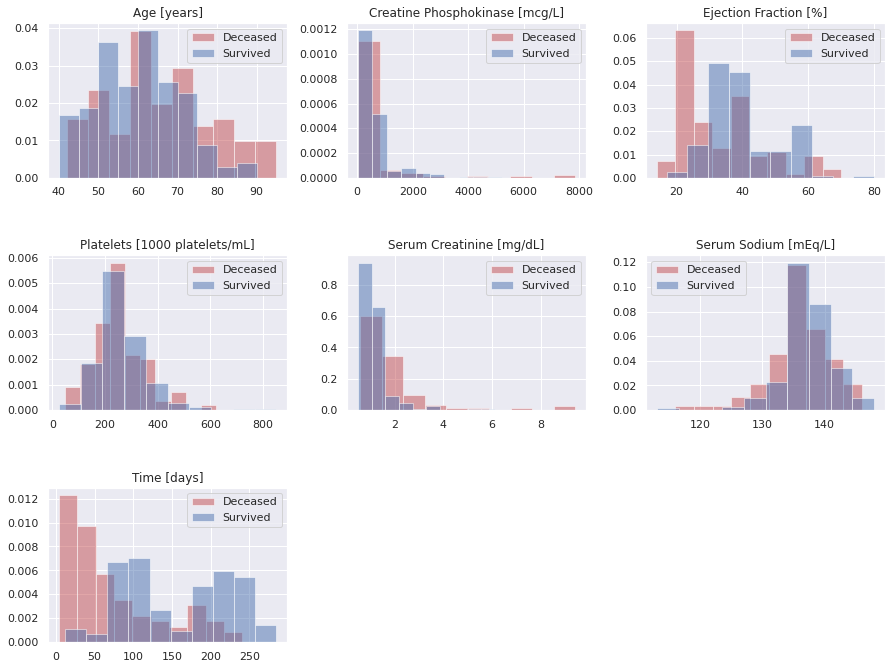

In [14]:
plot_features(binary=False, kind='hist', ncols=3)

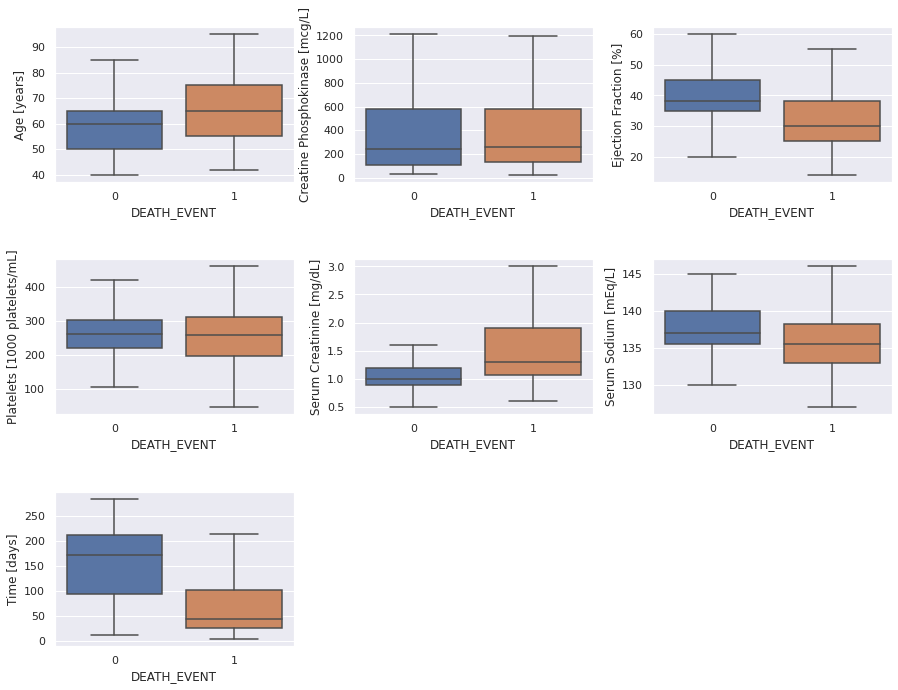

In [15]:
plot_features(binary=False, kind='box', ncols=3)

- **Age**: patients above the age of 70 are obviously at a higher risk
- **Ejection Fraction** is a strong predictor, especially below around 30 units
- **Serum Creatinine** is also a very strong feature, specifically about around 2 units
- **Serum Sodium** might be a helpful feature, but a little less so than the two previous ones
- **Follow-up Duration (Time)**: We can tell that the patient chance to die in the follow-up period roughly follows an exponential distribution, for those that will not survive, as one might expect. The meaning of the follow-up period for the survivors is different: it seems it merely reflects how long these patients were monitored. Let's have a closer look at this variable.

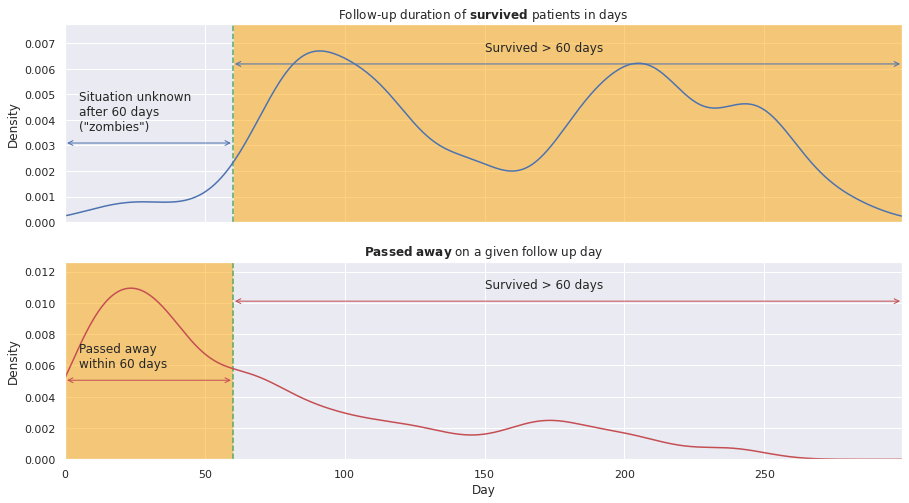

In [16]:
def plot_time(n_days=60):
    """Plot distribution of patient follow-up time for surviving
    and deceased patients."""
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
    KERNEL_WIDTH = 0.2  # KDE smoothing parameter

    # Configure what plots display
    from collections import namedtuple
    config = namedtuple('config',
                        ['text1', 'text2', 'title', 'colour', 'hlight'])
    survived_config =\
        config(f'Situation unknown\nafter {n_days} days\n("zombies")',
               f'Survived > {n_days} days',
               r'Follow-up duration of $\bf{survived}$ patients in days',
               'b', (n_days, 350))
    dead_config =\
        config(f'Passed away\nwithin {n_days} days',
               f'Survived > {n_days} days',
               r'$\bf{Passed}$ $\bf{away}$ on a given follow up day',
               'r', (0, n_days))
    configs = (survived_config, dead_config)

    max_time = 1.05 * df['Time [days]'].max()
    # Make the plots
    for i, ax in enumerate(axes):
        df[df[LABEL] == i]['Time [days]'].plot.kde(bw_method=KERNEL_WIDTH,
                                                   ax=ax,
                                                   color=configs[i].colour)
        ax.set_ylim(0, ax.get_ylim()[1] * 1.1)
        ax.set_title(configs[i].title)
        ax.set_xlabel('Day')

        ax.set_xlim(0, max_time)
        ax.vlines(x=[n_days],
                  ymin=0,
                  ymax=ax.get_ylim()[1],
                  color='g',
                  linestyles='dashed')

        ax.annotate(text=configs[i].text1,
                    xy=(5, 0.45 * ax.get_ylim()[1]),
                    xytext=(5, 0.45 * ax.get_ylim()[1]),
                    ha='left',
                    va='bottom')
        ax.annotate(text='',
                    xy=(0, 0.4 * ax.get_ylim()[1]),
                    xytext=(n_days, 0.4 * ax.get_ylim()[1]),
                    arrowprops=dict(arrowstyle='<->', color=configs[i].colour))

        ax.annotate(text=configs[i].text2,
                    xy=(n_days, 0.85 * ax.get_ylim()[1]),
                    xytext=(150, 0.85 * ax.get_ylim()[1]),
                    va='bottom')
        ax.annotate(text='',
                    xy=(n_days, 0.8 * ax.get_ylim()[1]),
                    xytext=(max_time, 0.8 * ax.get_ylim()[1]),
                    arrowprops=dict(arrowstyle='<->', color=configs[i].colour))

        ax.axvspan(*configs[i].hlight, facecolor='orange', alpha=0.5)


plot_time()

Interestingly, the 'Time' feature has different meaning for either category of patients:
- for **survived** patients: duration of the follow-up time
- for **deceased** patients: day of their passing

Therefore, the former ones might have passed away anytime after the follow-up termination.
For instance, they might have passed away anytime between their follow-up duration and the full 350-day period.
Hence, the patients that are potentially **dead don't die** in the data; they will be hereafter referred to as 'zombies' ;-).

As a break while reading this notebook I recommend the wonderful Sturgill Simpson's ["The Dead Don't Die" song](https://www.youtube.com/watch?v=xiukuoSjDj0) ;-)

Selecting the 'survivors' of follow-up duration greater than `m` days (`Time > m` days) means they have *certainly* survived the first `m` days.
On the other hand, to be consistent, we must choose the 'non-survivors' who have passed away *within* the first `m` days (`Time < m` days). The corresponding regions are highlighted in the graphs.

This way we will be able to analyse how likely a given patient is to survive `m` days, e.g. 2 months, after the heart failure.

The patients whose follow-up duration is smaller than $m$ need to be rejected, reducing our statistics.

Curiously, for the **survivors** (within `m` days) target label, we might also include the ones who passed away after `m` days. However, it seems preferable not to do this: I would rather tell a patient they are going to survive at least `m` days if they *might survive even longer* than that rather than if they are *bound to* pass away anywhere from the day `m+1` onwards. Both approaches are fine, though, as long as we remain clear.


At this point it is astonishing that the paper authors **ignored** the `Time` variable in one of their studies, trying to justify it as follows:
> In the previous part of the analysis, we excluded follow-up
time from the dataset because we preferred to focus on the
clinical features and to try to discover something meaningful about them.

This approach is evidently **biased** as they might have had contaminated train and test samples: people who *might* have died were considered *survivors*.

Let us see how many patients are we left with for various values of $m$.

Max sum arg: 70 days
Max F1 arg: 100 days


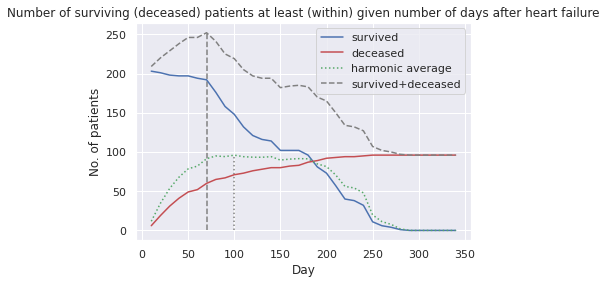

In [17]:
def plot_survived_died_period(n_min=10, n_max=350, step=10):
    days = []
    survived_arr = []
    deceased_arr = []
    f1 = []
    sum_all = []
    for n in range(n_min, n_max, step):
        days.append(n)
        survived = ((df[LABEL] == 0) & (df['Time [days]'] > n)).sum()
        survived_fr = survived / (df[LABEL] == 0).sum()
        died = ((df[LABEL] == 1) & (df['Time [days]'] < n)).sum()
        died_fr = died / (df[LABEL] == 1).sum()
        survived_arr.append(survived)
        deceased_arr.append(died)
        f1.append(2 * (survived * died) / (survived + died))
        sum_all.append(survived + died)
    max_sum_arg = np.argmax(sum_all)
    max_f1_arg = np.argmax(f1)
    print("Max sum arg:", days[max_sum_arg], "days")
    print("Max F1 arg:", days[max_f1_arg], "days")
    plt.plot(days, survived_arr, label='survived', color='b')
    plt.plot(days, deceased_arr, label='deceased', color='r')
    plt.plot(days, f1, label='harmonic average', color='g', linestyle='dotted')
    plt.plot(days,
             sum_all,
             label='survived+deceased',
             color='gray',
             linestyle='dashed')
    plt.vlines(x=days[max_sum_arg],
               ymin=0,
               ymax=sum_all[max_sum_arg],
               linestyles='dashed',
               colors='gray')
    plt.vlines(x=days[max_f1_arg],
               ymin=0,
               ymax=f1[max_f1_arg],
               linestyles='dotted',
               colors='gray')
    plt.xlabel("Day")
    plt.ylabel("No. of patients")
    plt.title(
        "Number of surviving (deceased) patients at least (within)"
        + " given number of days after heart failure"
    )
    plt.legend(loc='best')
    plt.show()


plot_survived_died_period()

Maximising harmonic average ensures the two variables are high and close by (i.e. balanced).
The harmonic average has an approximately plateau in the region around 75-175 days.
We might try to run the ML algorithms in that range.

The maximum harmonic average in on the 100-th day and the maximum sum of survived and deceased patients is achieved if we split at the 70-th day. If we want to have both, high statistics and good balance between the categories, we should consider splitting around the 75-100 days, yielding around 210-250 patients. Of course, all other values are technically possible, but they should yield less precise ML performance (which claim we might test).

We'll select, therefore, the highlighted below regions of either patient group.

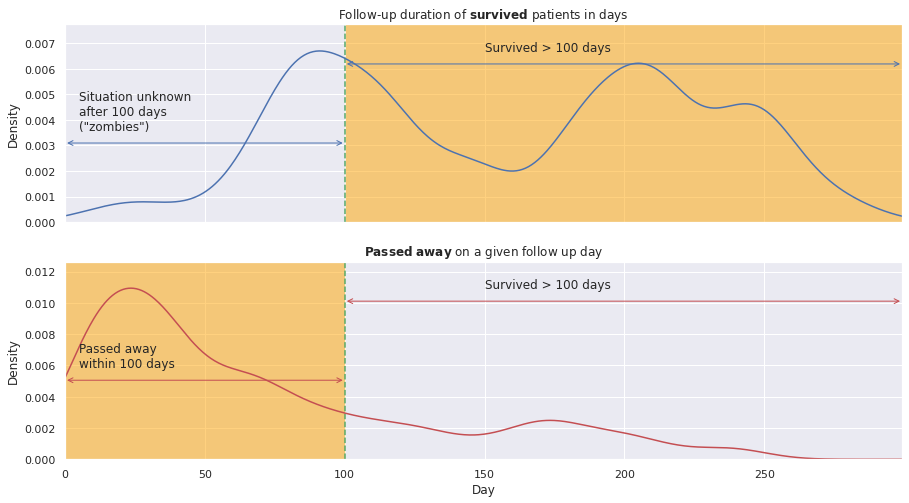

In [18]:
plot_time(100)

Finally, we'll save the dataset and feature metadata to pick up in the next steps.

In [19]:
import joblib
joblib.dump(df, "df.pkl")
joblib.dump(feature_metadata, "feature_metadata.pkl")

['feature_metadata.pkl']

As a sanity check, let's see if we can properly load the saved objects.

In [20]:
df = joblib.load("df.pkl")
df.head()

,Age [years],Anaemia,Creatine Phosphokinase [mcg/L],Diabetes,Ejection Fraction [%],High Blood Pressure,Platelets [1000 platelets/mL],Serum Creatinine [mg/dL],Serum Sodium [mEq/L],Male,Smoking,Time [days],DEATH_EVENT
0,75.0,0,582,0,20,1,265.00000,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263.35803,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162.00000,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210.00000,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327.00000,2.7,116,0,0,8,1


In [21]:
fm = joblib.load("feature_metadata.pkl")
fm

{'Age [years]': {'is_binary': False},
 'Anaemia': {'is_binary': True},
 'Creatine Phosphokinase [mcg/L]': {'is_binary': False},
 'Diabetes': {'is_binary': True},
 'Ejection Fraction [%]': {'is_binary': False},
 'High Blood Pressure': {'is_binary': True},
 'Platelets [1000 platelets/mL]': {'is_binary': False},
 'Serum Creatinine [mg/dL]': {'is_binary': False},
 'Serum Sodium [mEq/L]': {'is_binary': False},
 'Male': {'is_binary': True},
 'Smoking': {'is_binary': True},
 'Time [days]': {'is_binary': False},
 'DEATH_EVENT': {'is_binary': True}}

# Conclusions -- what I've learnt so far
- Feeding features directly to an ML algorithm is a *wrong* practise
- Meaning of target labels might be more subtle than it seems (here 'DEATH_EVENT' relates to another feature, follow-up time);
- Here, we must *extract* the target labels using another feature **before** making predictions
- Ignoring some features we do not understand is dangerous, especially if they somehow relate to the labels
- Be patient and use a "pause and think" (or "pause and plot") approach before any classification / regression
- Regarding data collection, the follow-up period should have been the same for each patient (if possible), e.g. 1 year. It is understandable, though, that it might have not been possible.

**In the next post** we'll implement a couple of classifiers to predict patient survival within 100 days after a heart failure.